In [11]:
from functions import *
from tqdm import tqdm

In [12]:
n = 6

In [13]:
def get_proposal_mat_quantum(m, gamma=0.7, t=1):
    '''Get a quantum proposal matrix for a given Ising model.'''

    H_zz = sum([-m.J_rescaled[i,j]*Z(i,m.n) @ Z(j,m.n) for i in range(m.n) for j in range(i+1,m.n)]) # note that the factor 1/2 is not needed here
    H_z = sum([-m.h_rescaled[i]*Z(i,m.n) for i in range(m.n)])
    H_x = sum([X(i,m.n) for i in range(m.n)])
    H = (1-gamma) *(H_zz + H_z) + gamma*H_x
    assert np.allclose(H.T, H), 'H must be symmetric.'
    
    U = sparse_la.expm(-1j * H * t) # time evoluiton operator
    proposal_mat = np.abs(U)**2

    assert is_stochastic(proposal_mat), 'Proposal matrix is not stochastic.'
    return proposal_mat

In [15]:
def quantum_proposal_mat_ideal(m):
    """
    Returns a 2**n * 2**n stochastic proposal matrix for our quantum method of suggesting moves,
    with no Trotter, gate or SPAM errors.
    """
    def cont_eig(Dlambda):
        t_0, t_f = 2, 20 # evolution time t ~ unif(t_0, t_f)
        x = np.sin(Dlambda*t_f) - np.sin(Dlambda*t_0) # from analytical expression for transition probabilities
        return np.divide(2*x/(t_f-t_0), Dlambda, out=np.ones_like(Dlambda), where=(Dlambda!=0) ) 

    # J_Q = problem_inst.J_rescaled
    # h_Q = problem_inst.h_rescaled
    n = m.n 

    # H_z = -1*sum([J_Q[i,j]*Z(i,n) @ Z(j,n) for i in range(n) for j in range(n)]) - sum([h_Q[i]*Z(i,n) for i in range(n)])
    H_zz = sum([-m.J_rescaled[i,j]*Z(i,m.n) @ Z(j,m.n) for i in range(m.n) for j in range(i+1,m.n)]) # note that the factor 1/2 is not needed here
    H_z = H_zz + sum([-m.h_rescaled[i]*Z(i,m.n) for i in range(m.n)])
    H_x = sum([X(i,n) for i in range(n)])

    d = 2**n
    a = np.arange(d**2)
    mask = (a//d >= a%d)
    ones = np.ones(d)

    # c is called gamma in paper
    c_lims = [0.25, 0.6] # sample c ~ unif(c_lims[0], c_lims[1])
    c_steps = 20 # approximate integral over c by Riemann sum with c_steps points
    c_starts, step_size = np.linspace(c_lims[0], c_lims[1], num=c_steps, endpoint=False, retstep=True)
    c_mids = c_starts + step_size/2

    prop_list = [None]*c_mids.size
    for c_ind, c in enumerate(c_mids):
        H = (1-c)*H_z + c*H_x
        vals, vecs = la.eigh(H)

        vals_diff = (np.kron(vals, ones) - np.kron(ones, vals))[mask]
        M = la.khatri_rao(vecs.T, vecs.T)[mask]
        prop_list[c_ind] = M.T * cont_eig(vals_diff) @ M 
    
    proposal_mat = sum(prop_list)/len(c_mids)
    return proposal_mat

In [16]:
m = RandomIsingModel(3)

In [17]:
np.random.seed(0) # set the seed for reproducibility

num_random_models = 50
num_temperatures = 10

T_arr = np.geomspace(0.01, 1000, num_temperatures)

delta_random_arr = np.zeros((num_temperatures, num_random_models))
delta_local_arr = np.zeros((num_temperatures, num_random_models))
delta_quantum_arr = np.zeros((num_temperatures, num_random_models))
delta_mismatched_quantum_arr = np.zeros((num_temperatures, num_random_models))

for T_index in tqdm(range(num_temperatures)):
    T = T_arr[T_index]
    for i in range(num_random_models):
        m = RandomIsingModel(n)

        proposal_mat_random = get_proposal_mat_random(m)
        P_random = get_transition_matrix(m, T, proposal_mat_random)
        delta_random = get_delta(P_random)
        delta_random_arr[T_index][i] = delta_random

        proposal_mat_local = get_proposal_mat_local(m)
        P_local = get_transition_matrix(m, T, proposal_mat_local)
        delta_local = get_delta(P_local)
        delta_local_arr[T_index][i] = delta_local
    
        proposal_mat_quantum = quantum_proposal_mat_ideal(m)
        P_quantum = get_transition_matrix(m, T, proposal_mat_quantum)
        delta_quantum = get_delta(P_quantum)
        delta_quantum_arr[T_index][i] = delta_quantum

        m_mismatched = RandomIsingModel(n)
        proposal_mat_mismatched_quantum = quantum_proposal_mat_ideal(m_mismatched)
        P_mismatched_quantum = get_transition_matrix(m, T, proposal_mat_mismatched_quantum)
        delta_mismatched_quantum = get_delta(P_mismatched_quantum)
        delta_mismatched_quantum_arr[T_index][i] = delta_mismatched_quantum

100%|██████████| 10/10 [02:28<00:00, 14.83s/it]


In [18]:
# num_random_models = 50
# num_temperatures = 10
# num_gammas = 10
# num_times = 20

# T_arr = np.geomspace(0.01, 100, num_temperatures)
# gammas = np.linspace(0.25, 0.6, num_gammas)
# times = np.linspace(2,20,num_times)
# # times = [10]
# # gammas = [0.4]

# delta_random_arr = np.zeros((num_temperatures, num_random_models))
# delta_local_arr = np.zeros((num_temperatures, num_random_models))
# delta_quantum_arr = np.zeros((num_temperatures, num_random_models, num_gammas, num_times))

# for T_index in tqdm(range(num_temperatures)):
#     T = T_arr[T_index]
#     for i in range(num_random_models):
#         m = RandomIsingModel(n)

#         proposal_mat_random = get_proposal_mat_random(m)
#         P_random = get_transition_matrix(m, T, proposal_mat_random)
#         delta_random = get_delta(P_random)
#         delta_random_arr[T_index][i] = delta_random

#         proposal_mat_local = get_proposal_mat_local(m)
#         P_local = get_transition_matrix(m, T, proposal_mat_local)
#         delta_local = get_delta(P_local)
#         delta_local_arr[T_index][i] = delta_local
    
#         for gamma_index in range(num_gammas):
#             gamma = gammas[gamma_index]
#             for time_index in range(num_times):
#                 t = times[time_index]
#                 proposal_mat_quantum = get_proposal_mat_quantum(m, gamma=gamma, t=t)
#                 P_quantum = get_transition_matrix(m, T, proposal_mat_quantum)
#                 delta_quantum = get_delta(P_quantum)
#                 delta_quantum_arr[T_index][i][gamma_index][time_index] = delta_quantum

In [19]:
delta_random_arr_avg = np.mean(delta_random_arr, axis=1)
delta_random_arr_std = np.std(delta_random_arr, axis=1)

delta_local_arr_avg = np.mean(delta_local_arr, axis=1)
delta_local_arr_std = np.std(delta_local_arr, axis=1)

delta_quantum_arr_avg = np.mean(delta_quantum_arr, axis=1)
delta_quantum_arr_std = np.std(delta_quantum_arr, axis=1)

delta_mismatched_quantum_arr_avg = np.mean(delta_mismatched_quantum_arr, axis=1)
delta_mismatched_quantum_arr_std = np.std(delta_mismatched_quantum_arr, axis=1)

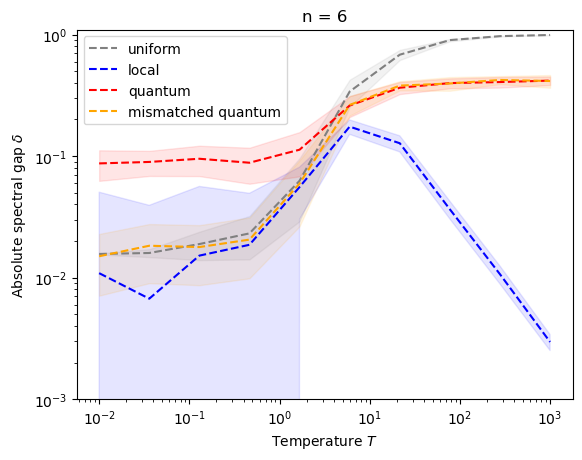

In [20]:
plt.plot(T_arr, delta_random_arr_avg, '--', color='grey', label = 'uniform')
plt.plot(T_arr, delta_local_arr_avg, '--', color='blue', label = 'local')
plt.plot(T_arr, delta_quantum_arr_avg, '--', color='red', label = 'quantum')
plt.plot(T_arr, delta_mismatched_quantum_arr_avg, '--', color='orange', label = 'mismatched quantum')

plt.fill_between(T_arr, 
                 delta_random_arr_avg-delta_random_arr_std, 
                 delta_random_arr_avg+delta_random_arr_std, 
                 color='grey',
                 alpha=0.1)
plt.fill_between(T_arr, 
                 delta_local_arr_avg-delta_local_arr_std, 
                 delta_local_arr_avg+delta_local_arr_std, 
                 color='blue',
                 alpha=0.1)
plt.fill_between(T_arr, 
                 delta_quantum_arr_avg-delta_quantum_arr_std, 
                 delta_quantum_arr_avg+delta_quantum_arr_std, 
                 color='red',
                 alpha=0.1)
plt.fill_between(T_arr, 
                 delta_mismatched_quantum_arr_avg-delta_mismatched_quantum_arr_std, 
                 delta_mismatched_quantum_arr_avg+delta_mismatched_quantum_arr_std, 
                 color='orange',
                 alpha=0.1)

plt.title(f'n = {n}')
plt.xlabel('Temperature $T$')
plt.ylabel('Absolute spectral gap $\delta$')
plt.ylim(0.001, 1.1)
plt.yscale('log')
plt.xscale('log')
plt.legend()